# Reinforcement Learning Project

Reinforcement learning project of ***Artificial Intelligence for Robotics 1*** of the master's course in *Robotics Engineering* at University of Genoa, curated by **Alessandro Trovatello**.

The aim of the project was to use the reinforcement learning to implement an Agent able to improve their skills to play at blackjack, using the **SARSA** method. The template was given by the professor and it's a custom openAI's Blackjack without the Agent. The Agent is fully created from zero using the *State - Action - Reward - nextState - nextAction* method.

## Blackjack game

The goal of the game is to beat the dealer by having a hand value of 21 or closest to 21 without going over. Each player is dealt two cards, and then has the option to "hit" and receive additional cards to improve their hand. They can also choose to “stand” and keep the cards they have. If the player exceeds 21, they “bust” and automatically lose the round. If the player has exactly 21, they automatically win. Otherwise, the player wins if they are closer to 21 than the dealer. \
The value of each card is listed below:
- 10/Jack/Queen/King → 10
- 2 through 9 → Same value as card
- Ace → 1 or 11 (Player’s choice)

The game starts with players making their bets, after which the dealer will deal two cards to each player and two to himself, with one card face up and one face down (known as the "hole" card). Players then make their decisions to hit or stand. Once all players have completed their turns, the dealer will reveal their hole card and hit or stand according to a set of rules. If the dealer busts (goes over 21), players who have not bust win. If neither the player nor dealer busts, the hand closest to 21 wins.

## Importing modules

The modules used here are to call the openAI environment, with `gym`, and the basic plotting scheme with `matplotlib` module. `random` is used as the main part regarding the cards dealing and other necessary data management.


In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import enum

## Setting up the basics of the game

### Card and deck

The cards' definitions are set up below. 
- `ranks`: a dictionary that maps the string representations of card ranks to their numerical values
- `Suit`: an enumeration of the four suits in a standard deck of playing cards
- `Card`: a class that represents an individual card and contains properties such as the card's suit, rank, and value
- `Deck`: a class that represents a deck of cards and contains methods for shuffling the deck, dealing cards, peeking at the top card, adding cards to the bottom of the deck, and printing the deck

The `Deck` class initializes an empty list of cards when created and populates it with `num` standard decks of playing cards. The `shuffle` method randomly shuffles the cards in the deck. The `deal` method returns the top card of the deck, and the `peek` method returns the top card without removing it from the deck. The `add_to_bottom` method adds a card to the bottom of the deck, and the `__str__` method returns a string representation of the deck. The `__len__` method returns the number of cards in the deck.

In [2]:
ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
    }

class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"
    
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value
    
class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

### Setting up the game's rules

The evaluation of the dealer's hand is done here, following a proper set of rules that are predictable. As the game goes, the dealer will be following *Hard 17* rule. This means the dealer will not hit again if the Ace yields a 17. This also means that Aces initially declared as 11's can be changed to 1's as new cards come.

In [3]:
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # It will be using Ace is equal to 1 in here
        else:
            use_one += card.value
    
    if num_ace > 0:
        ace_counter = 0
        while ace_counter < num_ace:
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

As for the evaluation of the player's hand, it focus on the value of Ace. For instance, if the Ace obtained gets the player to the total sum of 18 to 21, then Ace is equal to 11, otherwise it is equal to 1.

In [4]:
def player_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # It will be using Ace is equal to 1 in here
        else:
            use_one += card.value
    
    if num_ace > 0:
        ace_counter = 0
        while ace_counter < num_ace:
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

Below, the code for the logic in which the dealer will follow is presented. As the action is rather straightforward, nothing much happens. Following the Hard 17 rule, the dealer will stop hitting after the total is 17 or more and hit only if the player has no busted.

In [5]:
def dealer_turn(dealer_hand, deck, player_value):
    dealer_value = dealer_eval(dealer_hand)
    while dealer_value < 17 and player_value <= 21:
        dealer_hand.append(deck.deal()) # Making the Hit
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

## Setting up the OpenAI environment for Blackjack

The solution is to create a custom class in order to train and test the agent.

The class has two main attributes:
- the `action_space` attribute, which is a 2-element discrete space representing the two possible actions the player can take: hit (0) or stand (1)
- the `observation_space` attribute, which is a tuple representing the state of the game, consisting of two elements: player hand value (18 possible values ranging from 3 to 20) and the dealer's upcard value (10 possible values ranging from 2 to 11).

The class also implements four main methods:

- `step(action)` method, which takes the player's action as an input, updates the game state, calculates the reward, and returns the new state and the reward.
- `reset()` method, which resets the game to its initial state and returns the start state.
- `_take_action(action)` method, which updates the player's hand according to the player's action.
- `dealer_turn(dealer_hand, bj_deck)` method, which calculates the dealer's final hand value according to the dealer's rules.
- `render(game_num, action)` method, which print out the game status.

The game starts with an initial balance of 1000, and a deck of cards made up of 6 decks. The deck is initialized using the `Deck` class. The game can end in three ways: the player stands, the player's hand value exceeds 21, or the dealer's hand value exceeds 21. The rewards are -1 for losing, 0 for tie, and 1 for winning.

In [6]:
INITIAL_BALANCE = 1000
NUM_DECKS = 6

class BlackjackEnv(gym.Env):
    
    # Initialize the environment
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        
        # Initialize the blackjack deck.
        self.bj_deck = Deck(NUM_DECKS)
        
        self.player_hand = []
        self.dealer_hand = []
        
        self.reward_options = {"lose":-1, "tie":0, "win":1}
        
        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)
        
        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))

        self.done = False
    
    # Function to take an action in the game.
    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.bj_deck.deal())
            
        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = player_eval(self.player_hand)
    
    # Function to take a step in the game.
    def step(self, action):
        self._take_action(action)
        
        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21
        
        # rewards are 0 when the player hits and is still below 21, and they keep playing.
        self.rewards = 0
        
        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: # above 21, player loses automatically.
                self.rewards = self.reward_options["lose"]
            elif self.player_value == 21: # blackjack! Player wins automatically.
                self.rewards = self.reward_options["win"]
            else:
                ## Begin dealer turn phase.

                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck, self.player_value)
                
                ## End of dealer turn phase

                #------------------------------------------------------------#

                ## Final Compare

                if dealer_value > 21: # dealer above 21, player wins automatically
                    self.rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    self.rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        self.rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        self.rewards = self.reward_options["lose"]
                    else:
                        self.rewards = self.reward_options["tie"]
        
        self.balance += self.rewards
        
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
        
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        state = np.array([player_value_obs, upcard_value_obs])
        
        # convert the player hand into a tuple
        state = tuple(state)

        return state, self.rewards, self.done, {}
    
    # Function to reset the game state
    def reset(self):
        # Add the player and dealer cards back into the deck.
        self.bj_deck.cards += self.player_hand + self.dealer_hand

        # Shuffle before beginning. Only shuffle once before the start of each game.
        self.bj_deck.shuffle()
        
        # reset the done flag
        self.done = False 
        
        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]
        
        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
            
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        state = np.array([player_value_obs, upcard_value_obs])

        # convert the player hand into a tuple
        state = tuple(state)
        
        return state
    
    # Function to print out the game state
    def render(self, game_num, action):
        # Convert the player and dealer hand into a format that is
        # easy to read and understand.
        hand_list = []
        hand_list_dealer = []

        # Player hand
        for card in self.player_hand: 
            hand_list.append(card.rank)
         
        # Save the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])
        
        # Save the value of the dealer's hand.
        dealer_value, _, _ = dealer_turn(self.dealer_hand, self.bj_deck, self.player_value)
        
        # Dealer hand
        for card in self.dealer_hand: 
            hand_list_dealer.append(card.rank)

        # Convert the action into a string for a better understanding
        if action == 0:
            action = "Hit"
        elif action == 1:
            action = "Stand"

        # Print out the game state.
        print(f'Game Number: {(game_num+1)}')  
        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        if self.player_value <= 21:
            print(f'Player Action: {action}')
        # Print the dealer's hand only if the player has not busted
        if self.player_value <= 21 and action == 1:
            print(f'Dealer Hand: {hand_list_dealer}')
            print(f'Dealer Value: {dealer_value}')
        if self.done:
            if self.rewards == 1:
                print(f'Game over! Player WON!')
            elif self.rewards == -1:
                print(f'Game over! Player LOST!')
            elif self.rewards == 0:
                print(f'Game over! Tie!')
        print("-----------------------------------")

After the environment for Blackjack is created, it is necessary to create the Agent, requested in the project, that will learn how to play the game.

With the learning method of choice defined as the **SARSA**, a class `Agent` represents a reinforcement learning agent that can learn from its environment through trial and error. The agent has various attributes such as the environment it interacts with, its exploration factor `epsilon`, learning rate `alpha`, discount factor `gamma`, and the number of episodes it needs to train on `num_episodes_to_train`. The `Agent` class has several methods that allow it to learn from its interactions with the environment:
- `update_parameters` method: This method updates the exploration factor epsilon after each action the agent takes. The epsilon decreases over episodes and the agent becomes less explorative as it trains, so that it takes more exploitation-based decisions in the future.

- `create_Q_if_new_state` method: If the agent encounters a new state, it sets the initial values of the Q-values for each action to 0.0. The Q-values represent the expected long-term reward of taking a specific action in a specific state.

- `choose_action` method: Based on the current state, the agent uses this method to choose an action to take. If a random number in range [0,1] is greater or equal than the exploration factor epsilon, the agent chooses the action with the highest Q-value. Otherwise, it takes a random action.

- `learn` method: This method updates the Q-value of the action the agent took based on the reward it received and the utility of the next state. The new Q-value is computed using the SARSA formula that combines the current Q-value with the immediate reward and the discounted utility of the next action, taking into account the discount factor gamma.

- `moving_average` function: To calculate the moving average with window size of 100, to plot better the result obtained.

The SARSA update formula can be expressed as follows:
$$Q(state, action) = Q(state, action) + alpha \cdot [reward + gamma \cdot Q(next\_state, next\_action) - Q(state, action)]$$
where:
- $Q(state, action)$ is the current Q-value for the current state and action.
- $alpha$ is the learning rate, controlling the size of the learning step.
- $reward$ is the immediate reward obtained by the agent.
- $gamma$ is the discount factor, indicating how much the agent values future rewards.
- $Q(next\_state, next\_action)$ is the estimated Q-value of the next state and next action.

Additionally, there are two function in which is possible to train and test the agent.

- `train` function: To train the Agent using the methods previously defined. The arameters are passed during the agent creation.

- `test` function: To test the Agent using the Q-Table trained. The exploration factor `epsilon` is set to zero to make sure the Agent take actions only from the Q-Table.


In [7]:
class Agent:
    
    # Initialize the agent
    def __init__(self, env, epsilon=1.0, alpha=0.1, gamma=0.1, num_episodes_to_train=100000): 
        self.env = env # Blackjack environment
        self.env.balance = INITIAL_BALANCE # Reset the balance to the initial balance
        self.epsilon = epsilon  # Exploration factor
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.num_episodes_to_train = num_episodes_to_train # Number of episodes to train on
        self.Q = {}  # Q-values table

    # Function to update parameters during training
    def update_parameters(self, episode):
        # Decrease exploration factor epsilon over time
        self.epsilon = max(0.1, min(1.0, 1.0 - np.log10((episode + 1) / 25)))
        # Update learning rate alpha
        #self.alpha = max(0.1, min(1.0, 1.0 - np.log10((episode + 1) / 25)))
    
    # Function to create a Q-value for a new state if the state is new
    def create_Q_if_new_state(self, state):
        # If the state is not in the Q-table
        if state not in self.Q:
            # Initialize Q-values to 0 for both actions
            self.Q[state] = [0.0, 0.0]  

    # Function to choose the action (hit or stand) based on the Q-values of the states
    # or a random action based on epsilon (for exploration)
    def choose_action(self, state):
        # If the next state is new, create a Q value for it
        self.create_Q_if_new_state(state)

        if np.random.rand() < self.epsilon:
            # Exploration: choose a random action
            return self.env.action_space.sample()  
        else:
            # Exploitation: choose the action with the highest Q-value
            return np.argmax(self.Q[state])

    # Function to update the Q-table using SARSA update rule
    def learn(self, state, action, reward, next_state, next_action):
        # If the next state is new, create a Q value for it
        self.create_Q_if_new_state(next_state)

        # SARSA update rule
        self.Q[state][action] = self.Q[state][action] + self.alpha * (
                reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
    
    # Function to calculate the moving average with window size of 100
    def moving_average(self, lst, window_size=100):
        return [sum(lst[i:i+window_size])/window_size for i in range(len(lst)-window_size+1)]

    # Function to train the agent    
    def train(self):
        # Reset the balance to the initial balance
        self.env.balance = INITIAL_BALANCE 
        # Define variables to track rewards
        win_rate = 0
        lose_rate = 0
        tie_rate = 0
    
        # Iterate over episodes
        for episode in range(self.num_episodes_to_train):

            # Reset the environment
            state = self.env.reset() 
            
            # Choose an action
            action = self.choose_action(state) 

            # Print the game
            env.render(episode, action)

            while True:
                
                # Take the action, and get the next_state, reward, and done information
                next_state, reward, done, _ = self.env.step(action)
        
                # Choose the next action 
                next_action = self.choose_action(next_state)

                # Learn from the experience
                self.learn(state, action, reward, next_state, next_action)
                
                # Print the updated game
                env.render(episode, action)

                # If the episode is done
                if done:
                    
                    # Save the number of win, lose, and tie
                    if reward == 1:
                        win_rate += 1
                    elif reward == -1:
                        lose_rate += 1
                    elif reward == 0:
                        tie_rate += 1

                    # Exit the loop
                    break

            # Update parameters (epsilon)
            self.update_parameters(episode)

        # Print the result of the training
        print("\nTrain completed!\nThe summary of the training is as follows:")
        print("Win Rate: ", round((win_rate / self.num_episodes_to_train)*100,1),"%")
        print("Lose Rate: ", round((lose_rate / self.num_episodes_to_train)*100,1),"%")
        print("Tie Rate: ", round((tie_rate / self.num_episodes_to_train)*100,1),"%")

    # Function to test the agent
    def test(self, num_episodes_to_test):
        # Set exploration factor to zero to test
        self.epsilon = 0
        # Reset the balance to the initial balance
        self.env.balance = INITIAL_BALANCE 
        # Define variables to track rewards
        win_rate = 0
        lose_rate = 0
        tie_rate = 0

        for episode in range(num_episodes_to_test):

            # Reset the environment
            state = self.env.reset()

            # Choose an action
            action = self.choose_action(state)
            
            while True:

                # Take the action, and get the next_state, reward, and done information
                next_state, reward, done, _ = self.env.step(action)

                # Choose the next action
                action = self.choose_action(next_state)

                
                # If the episode is done
                if done:
                    # Save the number of win, lose, and tie
                    if reward == 1:
                        win_rate += 1
                    elif reward == -1:
                        lose_rate += 1
                    elif reward == 0:
                        tie_rate += 1

                    # Exit the loop
                    break

            # Print the percentage of training
            percentage_complete = (episode + 1) / num_episodes_to_test * 100
            print(f"\rTesting progress: {int(percentage_complete)}%", end="")

        # Print the result of the testing
        print("\n\nTest completed!\nThe summary of the testing is as follows:\n")
        print(f"Balance: From initial {INITIAL_BALANCE} to {self.env.balance}")
        print("Win Rate: ", round(win_rate / num_episodes_to_test * 100, 1), "%")
        print("Lose Rate: ", round(lose_rate / num_episodes_to_test * 100, 1), "%")
        print("Tie Rate: ", round(tie_rate / num_episodes_to_test * 100, 1), "%")
            

Set up the environment and create the agent, defining the parameters wanted.

In [8]:
# Create Blackjack environment
env = BlackjackEnv()
# Create SARSA agent
sarsa_agent = Agent(env, epsilon=1.0, alpha=0.1, gamma=0.01, num_episodes_to_train=10000) 

Now let train the agent. The function will print out the status of each game to understand better how the game works. At the end of all matches a summary of the percentage of wins, losses and draws will be presented. The win rate will be lower than the actual win percentage because it includes the initial matches in which the agent performs random actions.

In [9]:
# Train the agent
sarsa_agent.train()

Game Number: 1
Balance: 1000
Player Hand: ['queen', 'ace']
Player Value: 21
Dealer Upcard: 10
Player Action: Hit
-----------------------------------
Game Number: 1
Balance: 1000
Player Hand: ['queen', 'ace', 'five']
Player Value: 16
Dealer Upcard: 10
Player Action: Hit
-----------------------------------
Game Number: 1
Balance: 999
Player Hand: ['queen', 'ace', 'five', 'nine']
Player Value: 25
Dealer Upcard: 10
Game over! Player LOST!
-----------------------------------
Game Number: 2
Balance: 999
Player Hand: ['nine', 'two']
Player Value: 11
Dealer Upcard: 4
Player Action: Hit
-----------------------------------
Game Number: 2
Balance: 1000
Player Hand: ['nine', 'two', 'king']
Player Value: 21
Dealer Upcard: 4
Player Action: Hit
Game over! Player WON!
-----------------------------------
Game Number: 3
Balance: 1000
Player Hand: ['two', 'seven']
Player Value: 9
Dealer Upcard: 3
Player Action: Stand
-----------------------------------
Game Number: 3
Balance: 1001
Player Hand: ['two', 's

Game Number: 732
Balance: 716
Player Hand: ['eight', 'four', 'five', 'jack']
Player Value: 27
Dealer Upcard: 10
Game over! Player LOST!
-----------------------------------
Game Number: 733
Balance: 716
Player Hand: ['ten', 'eight']
Player Value: 18
Dealer Upcard: 11
Player Action: Hit
-----------------------------------
Game Number: 733
Balance: 717
Player Hand: ['ten', 'eight', 'three']
Player Value: 21
Dealer Upcard: 11
Player Action: Hit
Game over! Player WON!
-----------------------------------
Game Number: 734
Balance: 717
Player Hand: ['seven', 'nine']
Player Value: 16
Dealer Upcard: 9
Player Action: Stand
-----------------------------------
Game Number: 734
Balance: 716
Player Hand: ['seven', 'nine']
Player Value: 16
Dealer Upcard: 9
Player Action: Stand
Game over! Player LOST!
-----------------------------------
Game Number: 735
Balance: 716
Player Hand: ['ace', 'five']
Player Value: 16
Dealer Upcard: 6
Player Action: Stand
-----------------------------------
Game Number: 735
B

Game Number: 2356
Balance: 283
Player Hand: ['six', 'jack']
Player Value: 16
Dealer Upcard: 3
Player Action: Stand
-----------------------------------
Game Number: 2356
Balance: 284
Player Hand: ['six', 'jack']
Player Value: 16
Dealer Upcard: 3
Player Action: Stand
Game over! Player WON!
-----------------------------------
Game Number: 2357
Balance: 284
Player Hand: ['four', 'nine']
Player Value: 13
Dealer Upcard: 6
Player Action: Stand
-----------------------------------
Game Number: 2357
Balance: 285
Player Hand: ['four', 'nine']
Player Value: 13
Dealer Upcard: 6
Player Action: Stand
Game over! Player WON!
-----------------------------------
Game Number: 2358
Balance: 285
Player Hand: ['ace', 'ace']
Player Value: 12
Dealer Upcard: 5
Player Action: Stand
-----------------------------------
Game Number: 2358
Balance: 284
Player Hand: ['ace', 'ace']
Player Value: 12
Dealer Upcard: 5
Player Action: Stand
Game over! Player LOST!
-----------------------------------
Game Number: 2359
Balanc

Game Number: 3641
Balance: -116
Player Hand: ['two', 'king']
Player Value: 12
Dealer Upcard: 4
Player Action: Hit
-----------------------------------
Game Number: 3641
Balance: -115
Player Hand: ['two', 'king', 'nine']
Player Value: 21
Dealer Upcard: 4
Player Action: Hit
Game over! Player WON!
-----------------------------------
Game Number: 3642
Balance: -115
Player Hand: ['queen', 'six']
Player Value: 16
Dealer Upcard: 4
Player Action: Hit
-----------------------------------
Game Number: 3642
Balance: -115
Player Hand: ['queen', 'six', 'ace']
Player Value: 17
Dealer Upcard: 4
Player Action: Hit
-----------------------------------
Game Number: 3642
Balance: -116
Player Hand: ['queen', 'six', 'ace', 'king']
Player Value: 27
Dealer Upcard: 4
Game over! Player LOST!
-----------------------------------
Game Number: 3643
Balance: -116
Player Hand: ['jack', 'six']
Player Value: 16
Dealer Upcard: 7
Player Action: Stand
-----------------------------------
Game Number: 3643
Balance: -117
Playe

Game Number: 4883
Balance: -444
Player Hand: ['ten', 'nine']
Player Value: 19
Dealer Upcard: 11
Player Action: Stand
-----------------------------------
Game Number: 4883
Balance: -443
Player Hand: ['ten', 'nine']
Player Value: 19
Dealer Upcard: 11
Player Action: Stand
Game over! Player WON!
-----------------------------------
Game Number: 4884
Balance: -443
Player Hand: ['three', 'four']
Player Value: 7
Dealer Upcard: 5
Player Action: Stand
-----------------------------------
Game Number: 4884
Balance: -442
Player Hand: ['three', 'four']
Player Value: 7
Dealer Upcard: 5
Player Action: Stand
Game over! Player WON!
-----------------------------------
Game Number: 4885
Balance: -442
Player Hand: ['five', 'four']
Player Value: 9
Dealer Upcard: 10
Player Action: Hit
-----------------------------------
Game Number: 4885
Balance: -442
Player Hand: ['five', 'four', 'eight']
Player Value: 17
Dealer Upcard: 10
Player Action: Hit
-----------------------------------
Game Number: 4885
Balance: -44

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Once the training is complete, we can test the agent using only the decisions made through the Q-table. In this way, it is possible to see the actual win rate. There will be also a balance to compare the initial balance to the final one after `num_episodes_to_test` games.

In [10]:
# Test the agent
sarsa_agent.test(num_episodes_to_test=10000)

Testing progress: 13%

Testing progress: 23%

Testing progress: 32%

Testing progress: 43%

Testing progress: 54%

Testing progress: 69%

Testing progress: 80%

Testing progress: 90%

Testing progress: 97%

Testing progress: 100%

Test completed!
The summary of the testing is as follows:

Balance: From initial 1000 to 361
Win Rate:  42.9 %
Lose Rate:  49.3 %
Tie Rate:  7.8 %


Now, after trained and tested the agent, we can start a simulation of the work done. The simulation is run for 1000 `rounds` with 1000 `samples` to calculate the average payout per round, starting from an `INITIAL_BALANCE` of 1000. The agent's average payout is then plotted and printed, with the running average present for easier comprehension.

The plot shows how the agent learns to play, sample after sample; the result remains constant after approximately 100/150 samples, having updated `epsilon` at the end of each sample. So, to clarify, the agent will play with the same `epsilon` for `num_rounds` games, after that, `epsilon` is updated and the agent will play again `num_rounds` games, all for `num_samples` times. In addition to depending on `epsilon`, the result also depends on the **hyperparameters**, i.e. `alpha` and `gamma`; if we want to notice steeper learning, we can raise the *learning rate* `alpha` but the result it will be worst. The best way to obtain better results is to play with these values.

Training progress: 100%

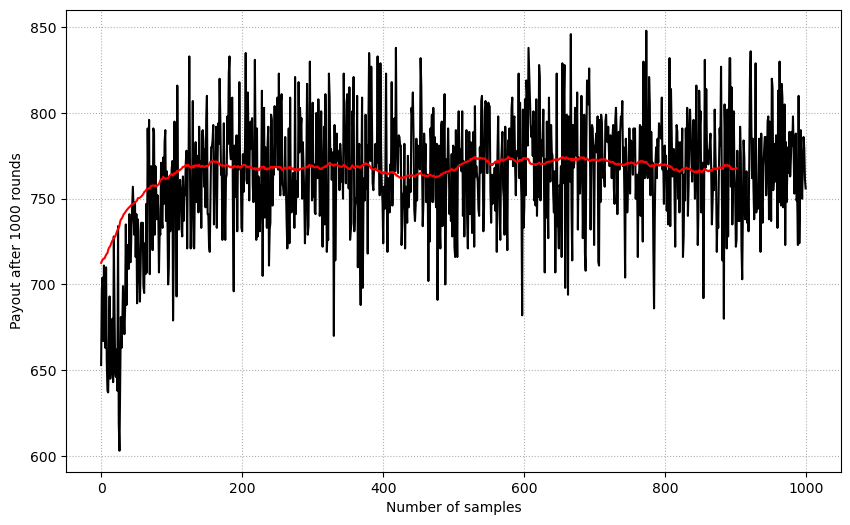

Average payout after 1000 rounds is: 762.98


In [11]:
# Loading the custom model
env = BlackjackEnv()

# Create SARSA agent
agent = Agent(env, epsilon=1.0, alpha=0.001, gamma=0.01, num_episodes_to_train=None)

# Payout calculated over num_rounds
num_rounds = 1000

# num_rounds simulated over num_samples
num_samples = 1000

# Store payout per round
average_rewards = []

# Set up the initial state
state = env.reset()

for sample in range(num_samples):
    # Initialize the round value over a sample
    rounds = 1
    # To store total payout over 'num_rounds'
    total_rewards = INITIAL_BALANCE
    
    # Take action based on Q-table of the agent and learn based on that until round = num_rounds
    while rounds <= num_rounds:
        # Choose an action
        action = agent.choose_action(state)

        # Take the action, and get the next_state, reward, and done information
        next_state, reward, is_done, _ = env.step(action)

        # Choose the next action
        next_action = agent.choose_action(next_state)

        # Learn from the experience and update the Q-table
        agent.learn(state, action, reward, next_state, next_action)

        # Update the total rewards
        total_rewards += reward

        # If the game is over, reset the state
        if is_done:
            # Environment deals new cards to player and dealer
            state = env.reset()
            # Increment the round
            rounds += 1
            
    # Track rewards
    average_rewards.append(total_rewards)

    # Update parameters (epsilon)
    agent.update_parameters(sample)

    # Print the percentage of training
    percentage_complete = (sample + 1) / num_samples * 100
    print(f"\rTraining progress: {int(percentage_complete)}%", end="")

# Calculate average rewards
avg_run = agent.moving_average(average_rewards)

# Plot the graph for average rewards per round for each sample
plt.figure(figsize=(10,6))
plt.plot(average_rewards, 'k-')
plt.plot(avg_run, 'r-')
plt.xlabel('Number of samples')
plt.ylabel('Payout after {} rounds'.format(num_rounds))
plt.grid(linestyle=':')
plt.show()      
    
print ("Average payout after {} rounds is: {}".format(num_rounds, round(sum(average_rewards)/(num_samples),2)))


Also in this case, the average payout after 1000 rounds is influenced by the initial samples in which the player does not know how to play.

To confirm the graph, it can be run the test with 1000 games with the same agent! 

In [12]:
agent.test(num_episodes_to_test=1000)

Testing progress: 73%

Testing progress: 100%

Test completed!
The summary of the testing is as follows:

Balance: From initial 1000 to 946
Win Rate:  44.3 %
Lose Rate:  49.7 %
Tie Rate:  6.0 %
